In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA 
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score,\
                            auc, roc_curve, roc_auc_score

import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px

In [2]:
# read in the dataset

df = pd.read_csv('../data/diabetes.csv')

In [3]:
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info() ## all numeric fields -> describe method would be useful
          ## no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

# Glucose, BP, SkinThickness, Insulin, BMI -> 0s are not valid values

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Data Cleaning

In [6]:
# check for 0 values for each column

columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns:
    
    display(df.loc[df[col] < 1].shape)
    
# glucose - 5
# bloodpressure - 35
# skinthickness - 227
# insulin - 374
# bmi - 11

(5, 9)

(35, 9)

(227, 9)

(374, 9)

(11, 9)

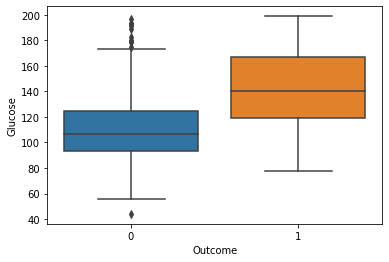

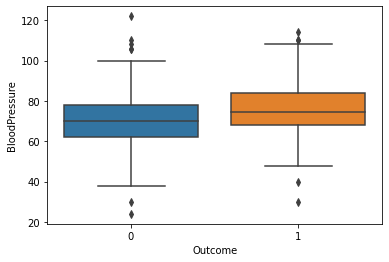

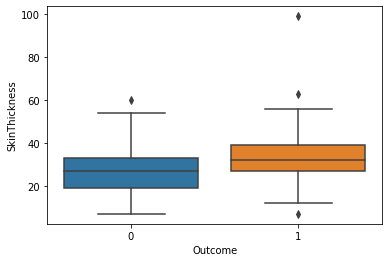

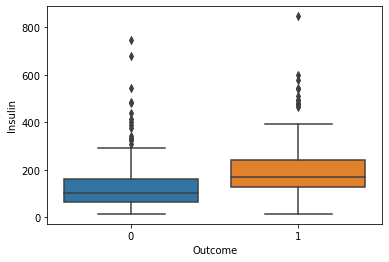

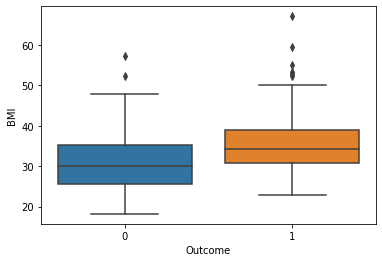

In [7]:
# check for outliers before imputing mean/median 

for col in columns:
    sns.boxplot(x = 'Outcome', y = col, data = df.loc[df[col] > 0])
    plt.savefig(f'../images/{col}_box.png')
    plt.show()
    
# median is the best imput method

In [8]:
# get the median values for each row by group

for col in columns:
    col = pd.DataFrame(df[df[col] > 0].groupby('Outcome').median()[col])
    display(col)

,Glucose
Outcome,
0,107
1,140


,BloodPressure
Outcome,
0,70.0
1,74.5


,SkinThickness
Outcome,
0,27.0
1,32.0


,Insulin
Outcome,
0,102.5
1,169.5


,BMI
Outcome,
0,30.1
1,34.3


In [9]:
# replace values with median

df_g = df[df['Outcome'] == 0]

df_g['Glucose'].replace(0, 107, inplace = True)
df_g['BloodPressure'].replace(0, 70, inplace = True)
df_g['SkinThickness'].replace(0, 27, inplace = True)
df_g['Insulin'].replace(0, 102, inplace = True)
df_g['BMI'].replace(0.0, 30.1, inplace = True)

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
# replace values with median

df_f = df[df['Outcome'] == 1]

df_f['Glucose'].replace(0, 140, inplace = True)
df_f['BloodPressure'].replace(0, 74, inplace = True)
df_f['SkinThickness'].replace(0, 32, inplace = True)
df_f['Insulin'].replace(0, 169, inplace = True)
df_f['BMI'].replace(0.0, 34.3, inplace = True)

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
# combine the two datasets with replaced values

df = pd.concat([df_g, df_f], sort = False)

In [12]:
# check the dataframe

print(df.shape)

df.describe()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.378906,29.089844,141.510417,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.104431,8.890820,89.140952,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.000000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## EDA

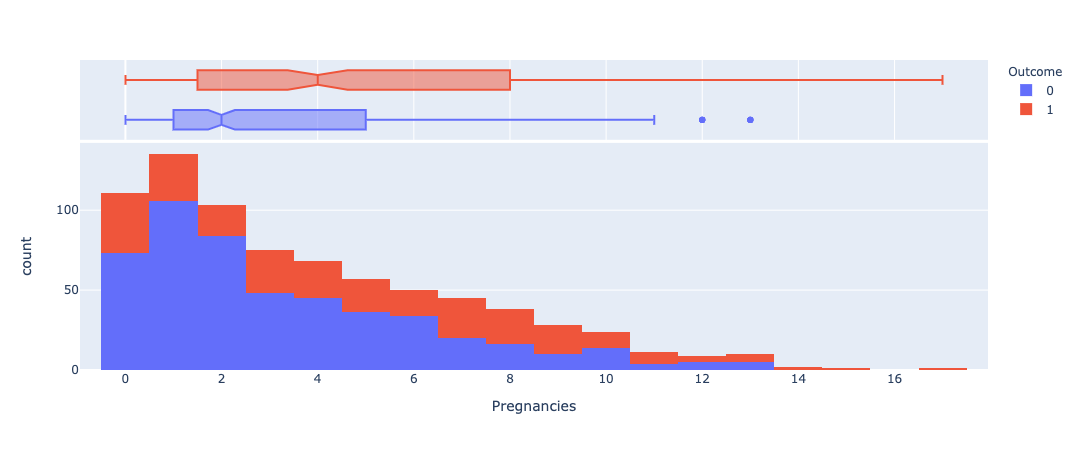

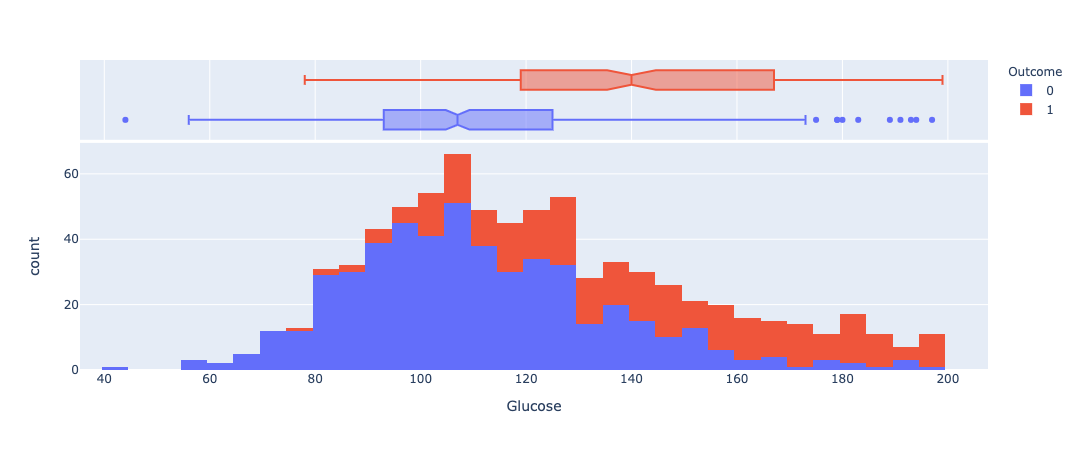

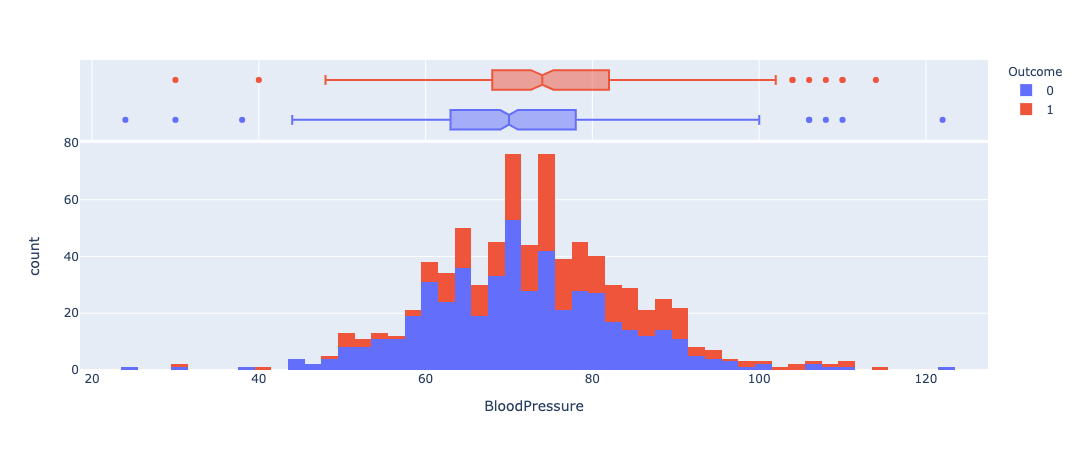

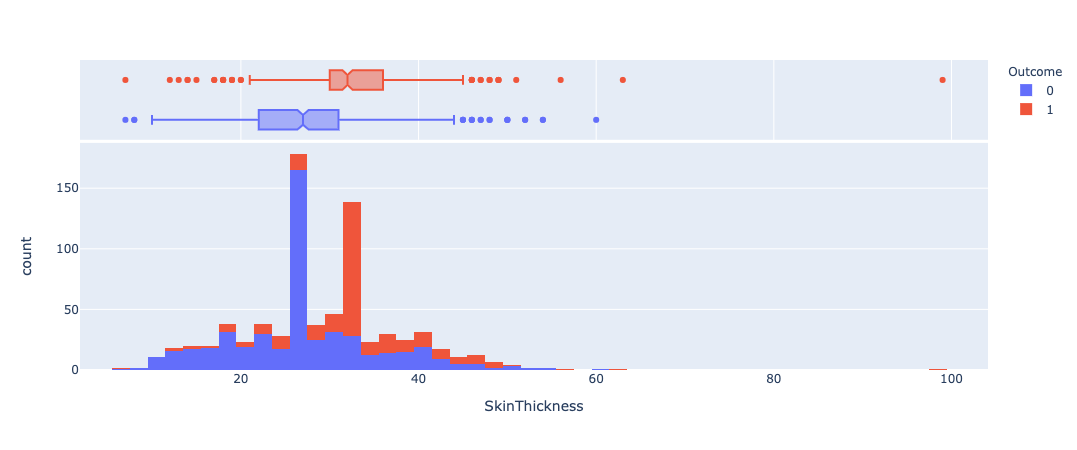

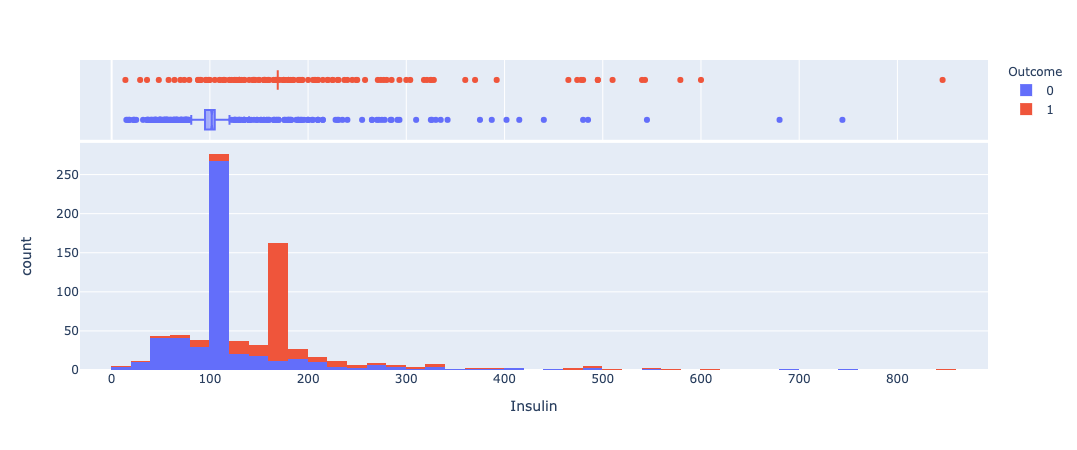

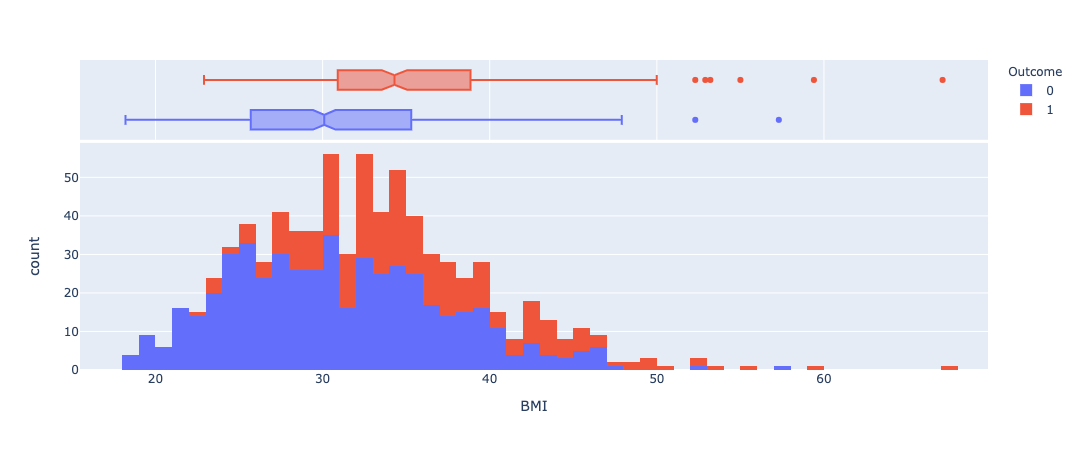

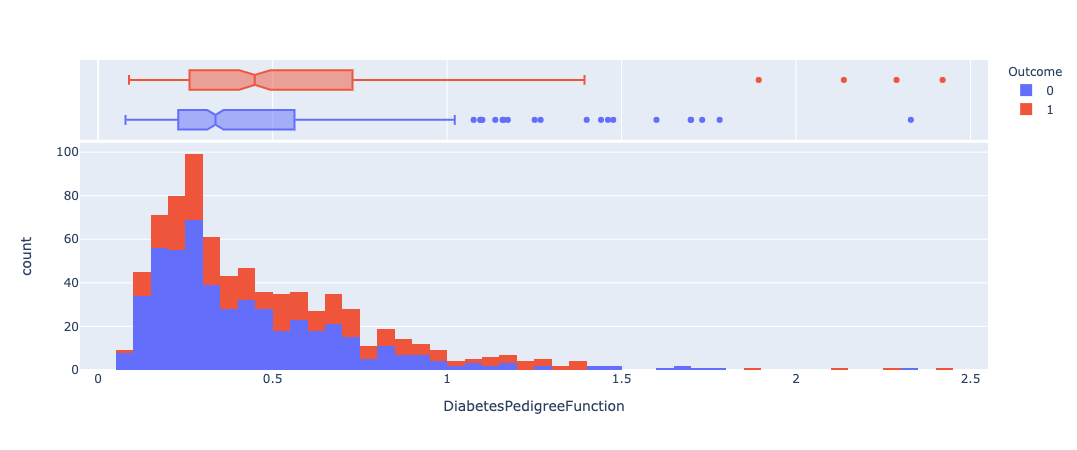

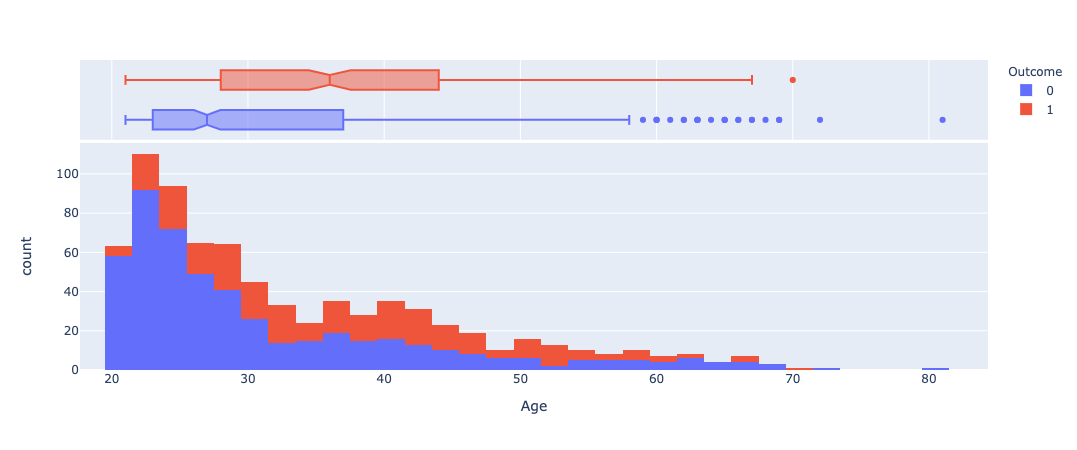

In [14]:
# distribution of each columns

columns = [col for col in df.columns if col != 'Outcome']

for col in columns:
    fig = px.histogram(df, x = col, color = 'Outcome', marginal = 'box', hover_data = columns)
    pyo.iplot(fig)
    fig.write_html(f'../images/{col}.html')

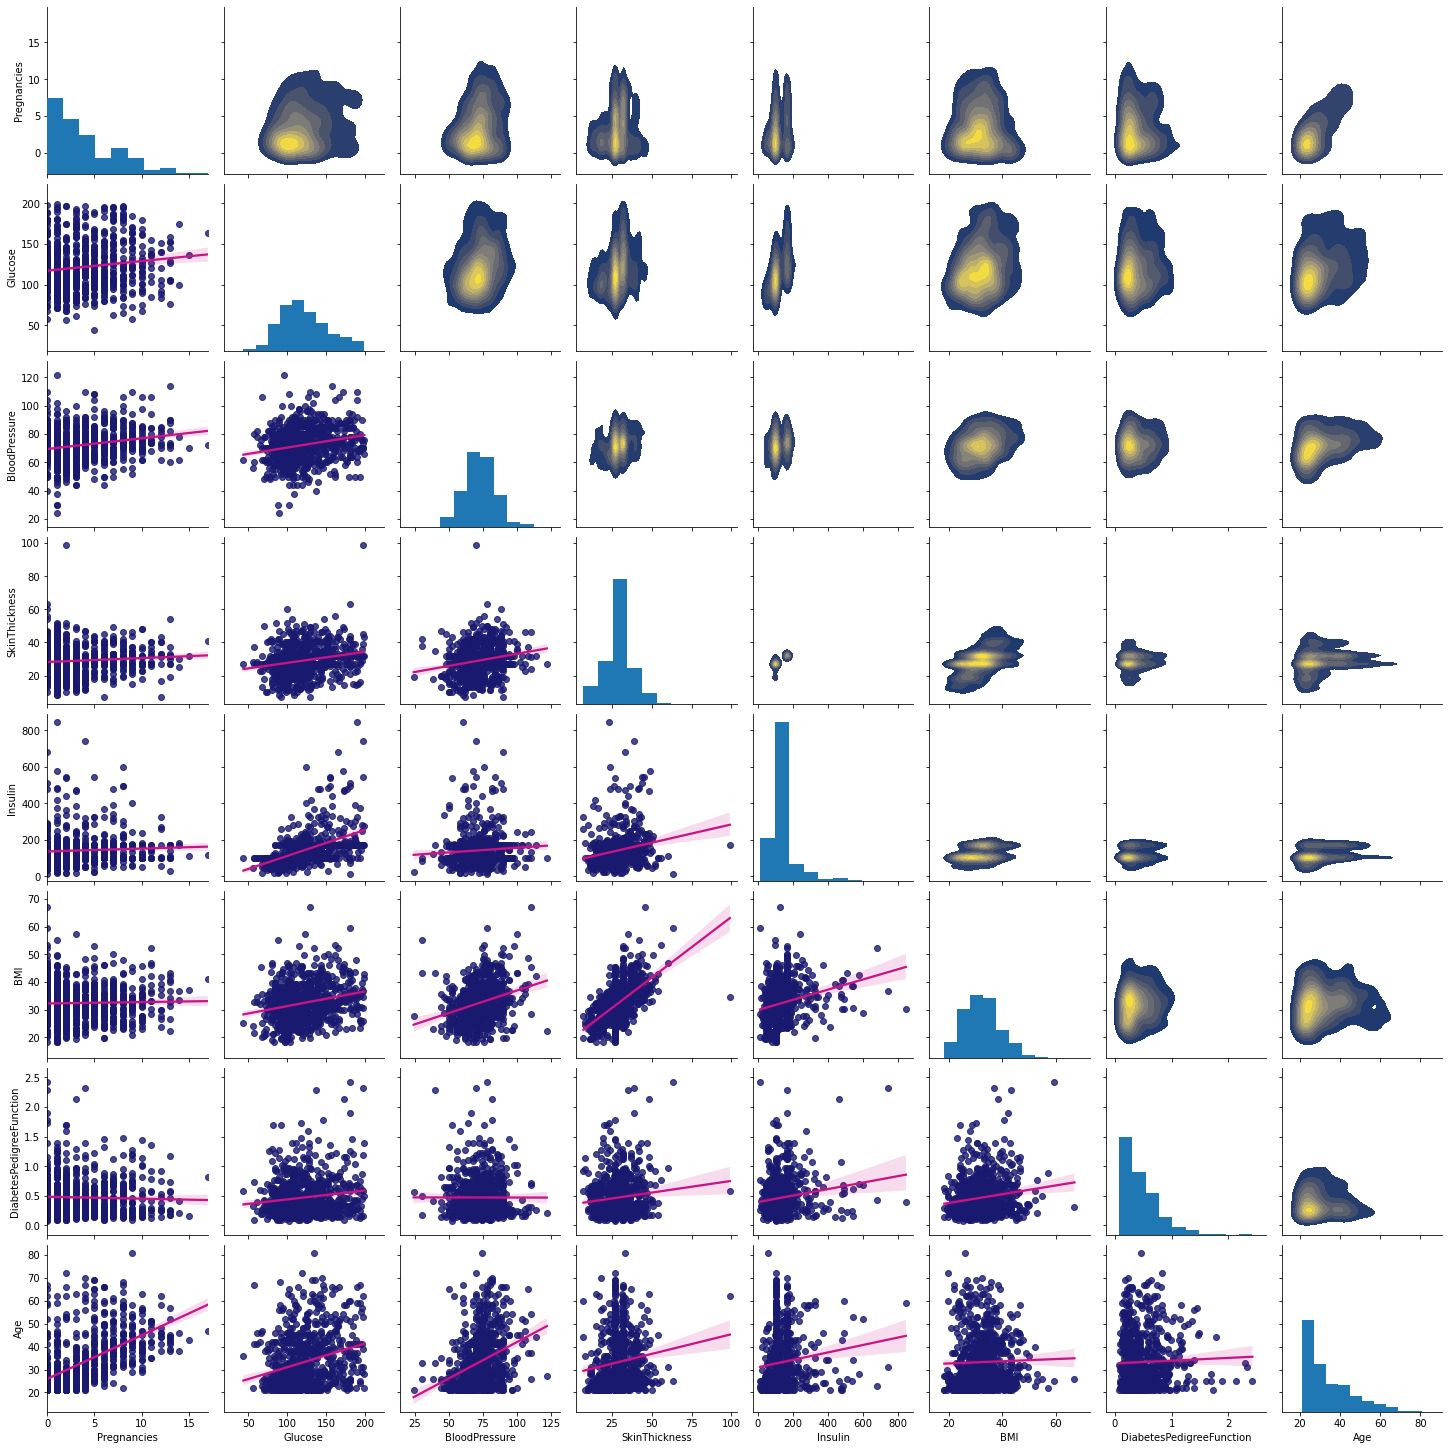

In [15]:
# pairplot

g = sns.PairGrid(df[columns])
g = g.map_lower(sns.regplot, scatter_kws = {'color': 'midnightblue'}, line_kws = {'color': 'mediumvioletred'})    
g = g.map_upper(sns.kdeplot, cmap = 'cividis', shade = True, shade_lowest = False) 
g = g.map_diag(plt.hist)       

plt.savefig('../images/pairgrid.png')
plt.show();

## Prediction

In [16]:
# train test split

X = df.drop(columns = ['Outcome'], axis = 1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020, test_size = 0.66, stratify = y)

In [17]:
# establish baseline

y.value_counts(normalize = True) # --> our model should do better than this

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [18]:
# instantiate standardscaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
# instantiate PCA

pca = PCA(random_state = 2020)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [20]:
# instantiate logistic regression

log = LogisticRegression()

log.fit(X_train, y_train)

LogisticRegression()

In [21]:
# predict

y_preds = log.predict(X_test)

# confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

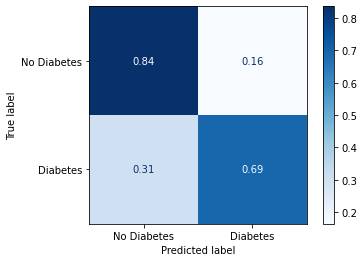

In [22]:
# view confusion matrix

labels = ['No Diabetes','Diabetes']
plot_confusion_matrix(log, X_test, y_test, cmap = 'Blues', normalize = 'true')
plt.xticks(ticks = [0, 1], labels = labels)
plt.yticks(ticks = [0, 1], labels = labels)
plt.savefig('../images/log_confusion.png');

In [23]:
# accuracy score with logistic regression 

accuracy_score(y_test, y_preds)

0.7869822485207101

In [24]:
# instantiate SVC

svc = SVC(probability = True, random_state = 2020)

svc.fit(X_train, y_train)

SVC(probability=True, random_state=2020)

In [25]:
# predict

y_preds = svc.predict(X_test)

# confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

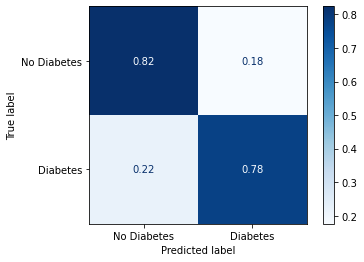

In [26]:
# view confusion matrix

labels = ['No Diabetes','Diabetes']
plot_confusion_matrix(svc, X_test, y_test, cmap = 'Blues', normalize = 'true')
plt.xticks(ticks = [0, 1], labels = labels)
plt.yticks(ticks = [0, 1], labels = labels)
plt.savefig('../images/svc_confusion.png');

In [27]:
# accuracy score with SVC

accuracy_score(y_test, y_preds)

0.8086785009861933

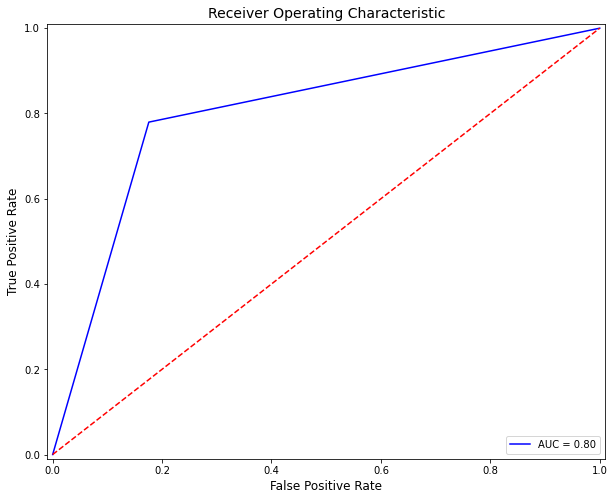

In [28]:
## plot AUC/ROC

# calculate the fpr and tpr for all thresholds of the classification

probs = svc.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

plt.figure(figsize = (10, 8))
plt.title('Receiver Operating Characteristic', size = 14)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate', size = 12)
plt.xlabel('False Positive Rate', size = 12)
plt.savefig('../images/auc.png');

In [ ]:
# visualizing test set result

from matplotlib.colors import ListedColormap 
  
X_set, y_set = X_test, y_test 
  
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01), 
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01)) 
  
plt.contourf(X1, X2, svc.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), 
             alpha = 0.75, cmap = ListedColormap('mistyrose', 'greenyellow'))  
  
plt.xlim(X1.min(), X1.max()) 
plt.ylim(X2.min(), X2.max()) 
  
for i, j in enumerate(np.unique(y_set)): 
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                c = ListedColormap('lightcoral', 'darkolivegreen')(i), label = j) 
plt.title('Support Vector Machine (Test set)')  
plt.xlabel('PC1') 
plt.ylabel('PC2')  
plt.legend() 
  
# show scatter plot 
plt.show() 